# Hypothesis

Given a users past shopping activity, we can accurately predict future purchases.

Initially, the model is based on:

* part of day (morning, eventing, afternoon, night)
* day (mon, tues...)
* amount spent
* market (Eua Claire, or Pittsville)
* Type of store (drug or supermarket)
* UPC (target, what product the user purchases)

Moving foward we can introduce demographic information into our model to improve accuracy.

In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, BaggingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import scale
from sklearn import datasets
import pandas as pd
from sklearn import preprocessing, cross_validation
from pandas.tools.plotting import scatter_matrix
from sklearn import grid_search
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor, DecisionTreeClassifier, ExtraTreeClassifier
from itertools import combinations
from sklearn import decomposition
from sklearn.metrics import mean_squared_error
from collections import Counter
from datetime import date, datetime

%pylab inline
pd.set_option('display.max_columns', 500)

Populating the interactive namespace from numpy and matplotlib


In [3]:
dr_sampling_rate=0.3
gr_sampling_rate=0.05

In [4]:
# local
saltsnck_dr_8=pd.read_fwf('saltsnck_drug_1479_1530').sample(frac=dr_sampling_rate)
saltsnck_dr_9=pd.read_fwf('saltsnck_drug_1531_1582').sample(frac=dr_sampling_rate)
saltsnck_dr_10=pd.read_fwf('saltsnck_drug_1583_1634').sample(frac=dr_sampling_rate)
saltsnck_dr_11=pd.read_fwf('saltsnck_drug_1635_1686').sample(frac=dr_sampling_rate)
saltsnck_dr_8_11=pd.concat([saltsnck_dr_8,saltsnck_dr_9,saltsnck_dr_10,saltsnck_dr_11]).reset_index(drop=True)
saltsnck_dr_8_11['OUTLET']='dr'

In [2]:
# local
sugarsub_dr_8=pd.read_fwf('sugarsub_drug_1479_1530')
sugarsub_dr_9=pd.read_fwf('sugarsub_drug_1531_1582')
sugarsub_dr_10=pd.read_fwf('sugarsub_drug_1583_1634')
sugarsub_dr_11=pd.read_fwf('sugarsub_drug_1635_1686')
sugarsub_dr_8_11=pd.concat([sugarsub_dr_8,sugarsub_dr_9,sugarsub_dr_10,sugarsub_dr_11]).reset_index(drop=True)
sugarsub_dr_8_11['OUTLET']='dr'

In [122]:
# local
coffee_dr_8=pd.read_fwf('coffee_drug_1479_1530')
coffee_dr_9=pd.read_fwf('coffee_drug_1531_1582')
coffee_dr_10=pd.read_fwf('coffee_drug_1583_1634')
coffee_dr_11=pd.read_fwf('coffee_drug_1635_1686')
coffee_dr_8_11=pd.concat([coffee_dr_8,coffee_dr_9,coffee_dr_10,coffee_dr_11]).reset_index(drop=True)
coffee_dr_8_11['OUTLET']='dr'

In [5]:
saltsnck_gr_8=pd.read_fwf('saltsnck_groc_1479_1530').sample(frac=gr_sampling_rate)
saltsnck_gr_9=pd.read_fwf('saltsnck_groc_1531_1582').sample(frac=gr_sampling_rate)
saltsnck_gr_10=pd.read_fwf('saltsnck_groc_1583_1634').sample(frac=gr_sampling_rate)
saltsnck_gr_11=pd.read_fwf('saltsnck_groc_1635_1686').sample(frac=gr_sampling_rate)
saltsnck_gr_8_11=pd.concat([saltsnck_gr_8,saltsnck_gr_9,saltsnck_gr_10,saltsnck_gr_11]).reset_index(drop=True)
saltsnck_gr_8_11['OUTLET']='gr'

In [123]:
saltsnck_prod = pd.read_excel('prod11_saltsnck.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]
sugarsub_prod = pd.read_excel('prod11_sugarsub.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]
coffee_prod = pd.read_excel('prod11_coffee.xlsx')[['SY','GE','VEND','ITEM','L1','L2']]

In [152]:
trans_list = [saltsnck_dr_8_11,sugarsub_dr_8_11, coffee_dr_8_11]
prod_list = [saltsnck_prod,sugarsub_prod, coffee_prod]

In [153]:
from datetime import date, datetime
week_season_translation=pd.read_excel('IRI week translation_2008_2017.xls')
week_season_translation = week_season_translation[\
    ['IRI Week', u'Calendar week starting on',u'Calendar week ending on']]
# if the date falls between March 21 and June 20, it is spring. Regardless of the year. 
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('fall', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
    
def get_season(rawDate):
    aDate = rawDate
    if isinstance(aDate, datetime):
        aDate = aDate.date()
    aDate = aDate.replace(year=Y)
    
    return next(season for season, (start, end) in seasons
                if start <= aDate <= end)

week_season_translation['season'] = week_season_translation['Calendar week starting on']
week_season_translation['season'] = week_season_translation['season'].apply(get_season)
week_season_translation.rename(columns={'IRI Week':'WEEK'}, inplace=True)
week_season_translation['YEAR']=week_season_translation['Calendar week starting on'].apply(lambda x:x.year)
week_season_translation['MONTH']=week_season_translation['Calendar week starting on'].apply(lambda x:x.month)
week_season_translation.drop(['Calendar week starting on','Calendar week ending on'], axis=1, inplace=True)

In [154]:
def data_agg(trans_list, prod_list,week_season_translation):
    agg_trans=pd.concat(trans_list)
    agg_prod=pd.concat(prod_list)
    agg_df = pd.merge(agg_trans, agg_prod, on=['SY', 'GE','VEND','ITEM']).drop(['SY', 'GE','VEND','ITEM'],axis=1)
    final_df = pd.merge(agg_df,week_season_translation,on='WEEK')
    return final_df

In [155]:
data_df=data_agg(trans_list, prod_list,week_season_translation)
data_df.head()

,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L1,L2,season,YEAR,MONTH
0,8002426,1530,1,1.29,NONE,0,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
1,8016830,1530,1,1.29,NONE,1,1,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
2,931511,1530,3,3.87,NONE,2,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
3,8009679,1530,2,2.58,NONE,2,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12
4,652759,1530,1,1.29,NONE,0,0,dr,CATEGORY - SALTY SNACKS,POTATO CHIPS,winter,2008,12


# Data Cleaning

## Handling NaNs

In [156]:
# looking at the number of NaNs for each column #
data_df.isnull().sum()

IRI_KEY    0
WEEK       0
UNITS      0
DOLLARS    0
F          0
D          0
PR         0
OUTLET     0
L1         0
L2         0
season     0
YEAR       0
MONTH      0
dtype: int64

In [157]:
def data_prep (data):
    # explicit mapping of F feature to reflect the ad size/importance
    data=data.copy()
    data.ix[data.F=='NONE', 'F'] = 1
    data.ix[data.F=='C', 'F'] = 2
    data.ix[data.F=='B', 'F'] = 3
    data.ix[data.F=='A', 'F'] = 4
    data.ix[data.F=='A+', 'F'] = 5
    # determining the non-numeric columns and transforming them into numeric using LabelEncoder() method
    real_or_str=data.applymap(np.isreal).all(0)
    non_num_feature=real_or_str[~real_or_str].keys()
    print "Non-numeric features are: ", non_num_feature
    le = preprocessing.LabelEncoder()
    for col in non_num_feature:
        #fill the NaN in non-numeric columns with the most used element#
        data.ix[:,col]=data.ix[:,col].fillna(data[col].describe().top)
        #transform the non-numeric columns to numeric values using 
        #LabelEncoder method from SKLearn#
        data.ix[:,col]=le.fit_transform(data.ix[:,col])
    #Filling in NaN values of numeric features with the mean value of the feature
    data=data.fillna(data.mean())
    return data

In [158]:
data_preped=data_prep(data_df)
data_preped.head()

Non-numeric features are:  Index([u'OUTLET', u'L1', u'L2', u'season'], dtype='object')


,IRI_KEY,WEEK,UNITS,DOLLARS,F,D,PR,OUTLET,L1,L2,season,YEAR,MONTH
0,8002426,1530,1,1.29,1,0,0,0,1,10,3,2008,12
1,8016830,1530,1,1.29,1,1,1,0,1,10,3,2008,12
2,931511,1530,3,3.87,1,2,0,0,1,10,3,2008,12
3,8009679,1530,2,2.58,1,2,0,0,1,10,3,2008,12
4,652759,1530,1,1.29,1,0,0,0,1,10,3,2008,12


In [159]:
def data_group(data_preped,outlet,method):
    if method=='yearly':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    elif method=='monthly':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','MONTH','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    elif method=='seasonal':
        data_preped_grp=data_preped.groupby(['IRI_KEY','YEAR','season','L1']).agg({'L2': lambda x:Counter(x).most_common()[0][0],\
                                             'OUTLET': lambda x:Counter(x).most_common()[0][0],\
                                            'F':'sum', 'D':'sum', 'PR':'sum', 'UNITS':'sum','DOLLARS':'sum'})\
                                            .reset_index(level=1).reset_index(level=1).reset_index(level=1).reset_index(drop=True)
    if outlet=='dr':                                        
        data_preped_grp=data_preped_grp.ix[data_preped_grp['OUTLET']==0]
    elif outlet=='gr':                                        
        data_preped_grp=data_preped_grp.ix[data_preped_grp['OUTLET']==1]
    elif outlet=='all':                                        
        data_preped_grp=data_preped_grp
    return data_preped_grp

In [184]:
data_preped_grp=data_group(data_preped,'dr','yearly')
data_preped_grp.head()

,L1,YEAR,PR,D,F,DOLLARS,L2,OUTLET,UNITS
0,0,2008,209,11,931,7096.06,4,0,1728
1,1,2008,262,95,1448,6263.88,10,0,4362
2,2,2008,39,0,208,1120.32,14,0,430
3,0,2009,290,44,1150,7665.73,4,0,1632
4,1,2009,324,258,1686,7898.74,10,0,5051


,L1,YEAR,PR,D,F,DOLLARS,L2,OUTLET,UNITS
count,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.000000,7101.0,7101.000000
mean,0.999859,2008.992395,139.172511,113.093085,612.329109,4215.106117,9.335305,0.0,1614.841290
std,0.810060,1.388260,151.305288,205.950451,657.214081,5986.237935,4.123048,0.0,2678.508739
min,0.000000,2007.000000,0.000000,0.000000,1.000000,0.750000,0.000000,0.0,1.000000
25%,0.000000,2008.000000,9.000000,0.000000,47.000000,231.230000,4.000000,0.0,78.000000
50%,1.000000,2009.000000,74.000000,11.000000,309.000000,1751.530000,10.000000,0.0,532.000000
75%,2.000000,2010.000000,244.000000,118.000000,1081.000000,6289.740000,14.000000,0.0,2077.000000
max,2.000000,2011.000000,1023.000000,1527.000000,3815.000000,75962.770000,16.000000,0.0,30984.000000


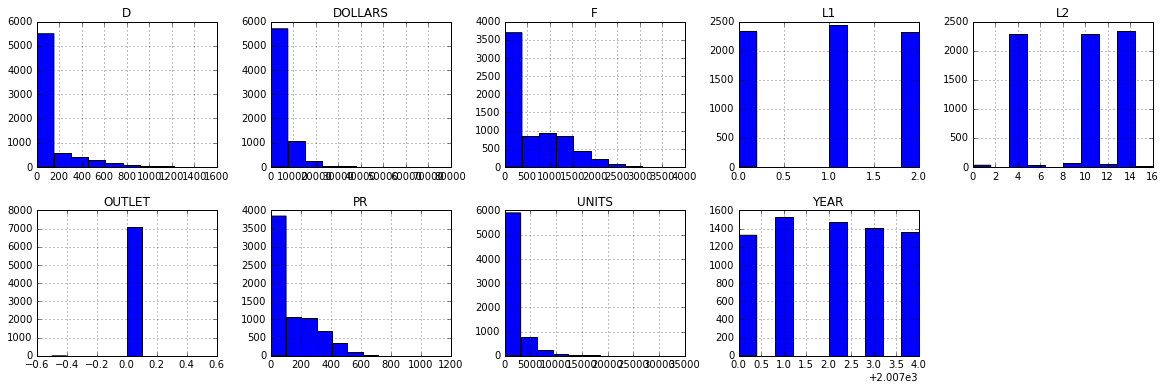

In [185]:
# looking at the histogram and statistics of the features to be able to omit features with not enough data #
data_preped_grp.hist(figsize=(20,50), layout=(15,5))
data_preped_grp.describe()

# Outlier Detection and Removal

**We assume that all features have Gaussian distribution and detect outliers based on the following rule:**

Detect a column with extreme outlier if $max (col)> mean(col)+10*\sigma $ 

In [186]:
def outlier_detector(data):
    out_col=[]
    data=data.copy()
    for col in data.describe().columns:
        maxx = data.describe()[col]['max']
        minn = data.describe()[col]['min']
        mean = data.describe()[col]['mean']
        std =  data.describe()[col]['std']

        if maxx>(mean+10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(data[col].ix[data[col]>(mean+10*std)].values)
            data=data[data[col]<(mean+10*std)]
        elif minn<(mean-10*std):
            out_col.append(col)
            print "outliers for column", col, "are",np.unique(saltsnck_preped[col].ix[saltsnck_preped[col]>(mean-10*std)].values)
            data=data[data[col]>(mean-10*std)]
    print "columns containing outliers are: ",out_col
    return data

In [187]:
data_preped_grp=outlier_detector(data_preped_grp)

outliers for column DOLLARS are [ 65323.39  70254.79  71730.87  75962.77]
outliers for column UNITS are [29390 30984]
columns containing outliers are:  ['DOLLARS', 'UNITS']


# Creating Model

# Natutral growth analysis

In [188]:
print "growth factor for 2011:", data_preped_grp.ix[data_preped_grp['YEAR']==2011][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2010:", data_preped_grp.ix[data_preped_grp['YEAR']==2010][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2009::", data_preped_grp.ix[data_preped_grp['YEAR']==2009][['DOLLARS']].sum()/(data_preped_grp.ix[data_preped_grp['YEAR']==2008][['DOLLARS']].sum())
print "growth factor for 2008:", 1

growth factor for 2011: DOLLARS    1.070066
dtype: float64
growth factor for 2010: DOLLARS    1.030598
dtype: float64
growth factor for 2009:: DOLLARS    0.978278
dtype: float64
growth factor for 2008: 1


# PCA Analysis

In [194]:
pca = decomposition.PCA()
pca.fit(X_train)
features = pca.transform(X_train)
pca.explained_variance_ratio_

array([  9.60415777e-01,   3.50907849e-02,   4.49229541e-03,
         1.14320704e-06,   0.00000000e+00])

# classifying the product category

### Decision Tree

In [189]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['L2']]
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['L2']]
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
print "score on train set:", dtree.score(X_train, y_train)
print "score on test set:", dtree.score(X_test, y_test)

score on train set: 0.992330486317
score on test set: 0.983063328424


# predicting the dollar amount

### Random Forest

In [230]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
tree = RandomForestRegressor(random_state=0)
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)

score on train set: 0.976247488597
score on test set: 0.880851140514


In [192]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['UNITS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['UNITS']
tree = RandomForestRegressor(random_state=0)
tree.fit(X_train, y_train)
print "score on train set:", tree.score(X_train, y_train)
print "score on test set:", tree.score(X_test, y_test)

score on train set: 0.974298175253
score on test set: 0.861411745343


In [234]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
parameters = {'n_estimators':range(10,101,10),'max_depth':range(1,10,5),\
              'min_samples_split':range(2,10,5),'min_samples_leaf':range(1,10,5)}
tree = RandomForestRegressor(warm_start=True)
clf = grid_search.GridSearchCV(tree, parameters, cv=10)
clf.fit(X_train, y_train)
print "The best set of parameters are: ", clf.best_params_
print "The best score is: ", clf.best_score_

The best set of parameters are:  {'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6, 'min_samples_leaf': 1}
The best score is:  0.870872358433


# Stacking

In [195]:
## writing a class with fit/predict/scoring method, to fit the sub-classifiers onto the data and fit
# a meta classifier on top of the base classifier and evaluate the performance
class stacked_classifier():
    def __init__(self, base_classifiers=None, meta_classifier=None):
        self.base_classifiers = base_classifiers
        self.meta_classifier = meta_classifier


    def fit(self, X, y):
        for classifier in self.base_classifiers:
            classifier.fit(X, y)
        X_meta=self.predict_base(X)
        self.meta_classifier.fit(X_meta, y)

    def predict_base(self, X):
        self.predictions = np.zeros(len(X))
        for classifier in self.base_classifiers:
            self.predictions=np.column_stack([self.predictions, classifier.predict(X)])
        return self.predictions
        
    def scoring(self,X,y):
        clf_score=[]
        for classifier in self.base_classifiers:
            clf_score.append(classifier.score(X, y))
        clf_score.append(self.meta_classifier.score(self.predict_base(X),y))
        return clf_score

# Creating sub and meta classifiers

In [203]:
DTC = DecisionTreeClassifier(random_state=0)
LR = linear_model.LogisticRegression()
RC =  linear_model.RidgeClassifier(random_state=0)
ETC = ExtraTreeClassifier(random_state=32)
KNC = KNeighborsClassifier ()
BC = BaggingClassifier()

In [225]:
DTR = DecisionTreeRegressor(random_state=0)
RR =  linear_model.Ridge(random_state=0)
BRR= linear_model.BayesianRidge()
ETR = ExtraTreeRegressor(random_state=0)
LR = linear_model.Lasso()
RFR = RandomForestRegressor(random_state=0)

# Importing the results of all possible combinations of base+meta classifier into a DataFrame

In [205]:
def stack_scoring(clf_dict, score_df, n, X_train, X_test, y_train, y_test):
    l=0
    for clf in combinations(clf_dict,n):
        stacked_clf=stacked_classifier(base_classifiers=clf[0:n-1], meta_classifier=clf[n-1])
        stacked_clf.fit(X_train,y_train)
        clf_scores=[clf_dict.get(clf[i]) for i in range(n)]+stacked_clf.scoring(X_test,y_test)
        score_df.loc[l]= clf_scores
        l+=1
    return score_df

In [206]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['L2']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['L2']
clf_dict={DTC: 'Decision Tree',LR:'Logistic Regression',RC: 'Ridge', ETC: 'Extra Tree', KNC:'KNeighbor', BC:'Bagging'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1          Logistic Regression
Base2                Decision Tree
Base3                        Ridge
Meta                     KNeighbor
Base1 Score               0.877911
Base2 Score               0.983063
Base3 Score               0.947717
Meta Score                0.984536
Name: 1, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Logistic Regression,Decision Tree,Ridge,Extra Tree,0.877911,0.983063,0.947717,0.983063
1,Logistic Regression,Decision Tree,Ridge,KNeighbor,0.877911,0.983063,0.947717,0.984536
2,Logistic Regression,Decision Tree,Ridge,Bagging,0.877911,0.983063,0.947717,0.980854
3,Logistic Regression,Decision Tree,Extra Tree,KNeighbor,0.877911,0.983063,0.983800,0.983063
4,Logistic Regression,Decision Tree,Extra Tree,Bagging,0.877911,0.983063,0.983800,0.981591
5,Logistic Regression,Decision Tree,KNeighbor,Bagging,0.877911,0.983063,0.913108,0.979381
6,Logistic Regression,Ridge,Extra Tree,KNeighbor,0.877911,0.947717,0.983800,0.984536
7,Logistic Regression,Ridge,Extra Tree,Bagging,0.877911,0.947717,0.983800,0.981591
8,Logistic Regression,Ridge,KNeighbor,Bagging,0.877911,0.947717,0.913108,0.982327
9,Logistic Regression,Extra Tree,KNeighbor,Bagging,0.877911,0.983800,0.913108,0.980854


In [228]:
X_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011][['PR','D','F','OUTLET','L1']]
y_train = data_preped_grp.ix[data_preped_grp['YEAR']!=2011]['DOLLARS']
X_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011][['PR','D','F','OUTLET','L1']]
y_test = data_preped_grp.ix[data_preped_grp['YEAR']==2011]['DOLLARS']
clf_dict={DTR: 'Decision Tree',RR: 'Ridge', ETR: 'Extra Tree', BRR:'Bayesian Ridge', LR:'Lasso', RFR: 'Random Forrest'}
score_df = pd.DataFrame(columns=['Base1','Base2','Base3', 'Meta','Base1 Score','Base2 Score','Base3 Score', 'Meta Score'])

stack_2_base_score = stack_scoring(clf_dict,score_df, 4, X_train, X_test, y_train, y_test)
print "Best stacked classifier with 2 sub-classifier is: \n", stack_2_base_score.loc[stack_2_base_score['Meta Score'].idxmax()]
stack_2_base_score

Best stacked classifier with 2 sub-classifier is: 
Base1                   Lasso
Base2          Bayesian Ridge
Base3          Random Forrest
Meta               Extra Tree
Base1 Score          0.692909
Base2 Score          0.692657
Base3 Score          0.880851
Meta Score           0.863544
Name: 14, dtype: object


,Base1,Base2,Base3,Meta,Base1 Score,Base2 Score,Base3 Score,Meta Score
0,Decision Tree,Ridge,Lasso,Bayesian Ridge,0.750570,0.692926,0.692909,0.750570
1,Decision Tree,Ridge,Lasso,Random Forrest,0.750570,0.692926,0.692909,0.751602
2,Decision Tree,Ridge,Lasso,Extra Tree,0.750570,0.692926,0.692909,0.750624
3,Decision Tree,Ridge,Bayesian Ridge,Random Forrest,0.750570,0.692926,0.692657,0.751053
4,Decision Tree,Ridge,Bayesian Ridge,Extra Tree,0.750570,0.692926,0.692657,0.752212
5,Decision Tree,Ridge,Random Forrest,Extra Tree,0.750570,0.692926,0.880851,0.783937
6,Decision Tree,Lasso,Bayesian Ridge,Random Forrest,0.750570,0.692909,0.692657,0.751056
7,Decision Tree,Lasso,Bayesian Ridge,Extra Tree,0.750570,0.692909,0.692657,0.752212
8,Decision Tree,Lasso,Random Forrest,Extra Tree,0.750570,0.692909,0.880851,0.785596
9,Decision Tree,Bayesian Ridge,Random Forrest,Extra Tree,0.750570,0.692657,0.880851,0.774660
